# Import Library

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pickle
import math
import time
import nltk
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer                           
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
import random
import string,re
import random
import matplotlib.pyplot as plt

In [2]:
nltk.download('stopwords')
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Cek Device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Import data dari Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Best Data

In [5]:
train_data = torch.load('/content/gdrive/My Drive/Skripsi/P1/train_loader.pt',)
validation_data = torch.load('/content/gdrive/My Drive/Skripsi/P1/valid_loader.pt')
test_data = torch.load('/content/gdrive/My Drive/Skripsi/P1/test_loader.pt')

In [6]:
display(train_data.dataset.tensors[0].size())
display(validation_data.dataset.tensors[0].size())
display(test_data.dataset.tensors[0].size())

torch.Size([489, 32])

torch.Size([389, 32])

torch.Size([49, 32])

In [7]:
data_train = []
label_train = []
for input,target in zip(train_data.dataset.tensors[0],train_data.dataset.tensors[1]):
  data_train.append(input)
  label_train.append(target)
data_train_2 = []
label_train_2 = []
for data in data_train:
  data_train_2.append(data.tolist())
for lab in label_train:
  label_train_2.append(lab.tolist())

In [8]:
data_val = []
label_val = []
for input,target in zip(validation_data.dataset.tensors[0],validation_data.dataset.tensors[1]):
  data_val.append(input)
  label_val.append(target)
data_val_2 = []
label_val_2 = []
for data in data_val:
  data_val_2.append(data.tolist())
for lab in label_val:
  label_val_2.append(lab.tolist())

In [9]:
data_test = []
label_test = []
for input,target in zip(test_data.dataset.tensors[0],test_data.dataset.tensors[1]):
  data_test.append(input)
  label_test.append(target)
data_test_2 = []
label_test_2 = []
for data in data_test:
  data_test_2.append(data.tolist())
for lab in label_test:
  label_test_2.append(lab.tolist())

In [10]:
data_train = torch.stack(data_train)
data_val = torch.stack(data_val)
data_test= torch.stack(data_test)

In [11]:
label_train = torch.stack(label_train)
label_val = torch.stack(label_val)
label_test = torch.stack(label_test)

In [12]:
train_data = TensorDataset(data_train, label_train)
valid_data = TensorDataset(data_val, label_val)
test_data = TensorDataset(data_test, label_test)

In [13]:
batch = 64

# make sure to SHUFFLE your data
# Masukkan data loader ke GPU
train_loader = DataLoader(train_data, shuffle=True, batch_size = batch, num_workers=0)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size = batch, num_workers=0)
test_loader = DataLoader(test_data, shuffle=True, batch_size = batch, num_workers=0)

# Best Model

In [71]:
best_model = torch.load('/content/gdrive/My Drive/Skripsi/Finale/best_model_sentiment_nets_82acc.pt')

##Import Data

In [15]:
df_tweet = pd.read_excel('/content/gdrive/My Drive/Skripsi/P1/P1_185150207111021_Alfen Hasiholan/tweet_1000.xlsx')[['tweet','sentiment']]

In [16]:
df_tweet

,tweet,sentiment
0,@mdevitoboutin @GulfFLLinda I hope you get bet...,0.0
1,#COVID19\n#COVID-19\n#COVID\n#Omicron \nThe CO...,0.0
2,@abcnews Because people are not falling for th...,1.0
3,wvstatejournal: RT @WVNews247: ACTIVE CASE COU...,1.0
4,@Unusual_Times I think there is a far bit of e...,1.0
...,...,...
995,If omicron is doing a better job than vaccines...,0.0
996,I'm not taking my mask off yet.\n\nCoronavirus...,1.0
997,It’s irrelevant whether you (falsely) believe ...,0.0
998,@lwtnikki Indeed they are! In Malaysia also we...,1.0


In [24]:
tokenized_tweet = pickle.load(open('/content/gdrive/My Drive/Skripsi/P1/tweet_1000_gloved.pkl', 'rb'))

In [25]:
padded_tweet = pickle.load(open('/content/gdrive/My Drive/Skripsi/P1/P1_185150207111021_Alfen Hasiholan/tokenized_tweets_paded_1000.pkl', 'rb'))

# Import GloVe Pre-trained

In [19]:
# import model glove dari library torchtext
glove_model = pickle.load(open('/content/gdrive/My Drive/Skripsi/P1/P1_185150207111021_Alfen Hasiholan/glove.pkl', 'rb'))

# Delete Netral Tweets

Delete tweets that have netral labels. (-)

In [20]:
df_tweet = df_tweet[df_tweet.sentiment != '-']
df_tweet.loc[:,'tweet'] = df_tweet['tweet'].astype('str')
df_tweet.loc[:,'sentiment'] = df_tweet['sentiment'].astype('int64')

# Preprocessing Tweet

First, create a slang word dictionary to convert slang words to its own origin words.

In [21]:
# Source : https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
slangs = {'afaik':'as far as i know','afk':' away from keyboard', 'asap': 'as soon as possible', 'atk': 'at the keyboard',
          'atm': 'at the moment', 'a3': 'anytime, anywhere, anyplace', 'bak': 'back at keyboard', 'bbl': 'be back later',
          'bbs': 'be back soon', 'bfn': 'bye for now', 'b4n': 'bye for now', 'brb' : 'be right back', 'brt': 'be right there',
          'btw': 'by the way', 'b4': 'before', 'b4n': 'bye for now', 'cu': 'see you', 'cul8r': 'see you later', 'cya': 'see you',
          'faq': 'frequently asked questions', 'fc': 'fingers crossed', 'fwiw': "for what it's worth", 'fyi': 'for your information',
          'gal': 'get a life', 'gg': 'good game', 'gn': 'good night', 'gmta': 'great minds think alike', 'gr8': 'great!', 'g9': 'genius',
          'ic': 'i see', 'icq': 'i seek you', 'ilu': 'i love you', 'imho': 'in my honest/humble opinion', 'imo': 'in my opinion', 
          'iow': 'in other words', 'irl': 'in real life', 'kiss': 'keep it simple, stupid', 'ldr': 'long distance relationship', 
          'lmao': 'laughing my ass off', 'lol': 'laughing out loud', 'ltns': 'long time no see', 'luv': 'love', 'l8r': 'later', 'mte': 'my thoughts exactly',
          'm8': 'mate', 'nrn': 'no reply necessary', 'oic': 'oh i see', 'pita': 'pain in the ass', 'prt': 'party', 'prw': 'parents are watching',
          'rofl': 'rolling on the floor laughing', 'roflol': 'rolling on the floor laughing out loud', 'rotflmao': 'rolling on the floor laughing my ass off',
          'sk8': 'skate', 'asl': 'age, sex, location', 'thx': 'thank you', 'ttfn': 'ta-ta for now!', 'ttyl': 'talk to you later', 
          'u': 'you', 'u2': 'you too', 'u4e': 'yours for ever', 'wb': 'welcome back', 'wtf': 'what the fuck', 'wtg': 'way to go!', 
          'wuf': 'where are you from?', 'w8': 'wait'}

In [22]:
# Sumber : https://gist.github.com/sebleier/554280
stopwords_2 = ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", 
              "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", 
              "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", 
              "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", 
              "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone",
              "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate",
              "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", 
              "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", 
              "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", 
              "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", 
              "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", 
              "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", 
              "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", 
              "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", 
              "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", 
              "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", 
              "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", 
              "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", 
              "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven",
              "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially",
              "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex",
              "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", 
              "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", 
              "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", 
              "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", 
              "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", 
              "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here",
              "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", 
              "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", 
              "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", 
              "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", 
              "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", 
              "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", 
              "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km",
              "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", 
              "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", 
              "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", 
              "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", 
              "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", 
              "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", 
              "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", 
              "ng", "ni", "nine", "nisentiment_netsy", "nj", "nl", "nn", "no", "nobody", "non", "none", "nosentiment_netsheless", "noone", "nor", "normally", "nos",
              "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", 
              "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", 
              "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", 
              "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", 
              "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", 
              "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", 
              "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", 
              "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", 
              "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", 
              "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro",
              "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", 
              "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", 
              "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", 
              "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", 
              "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", 
              "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", 
              "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", 
              "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", 
              "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", 
              "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", 
              "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", 
              "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", 
              "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", 
              "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", 
              "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", 
              "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", 
              "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", 
              "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", 
              "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", 
              "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", 
              "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", 
              "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", 
              "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", 
              "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", 
              "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", 
              "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", 
              "yr", "ys", "yt", "z", "zero", "zi", "zz"]

Change the ' character into ’.

In [26]:
def fix_stopword(sw):
    stopwordss = []
    for stopword in stopwords_2:
        if "'" in stopword:
            stopword = stopword.replace("'","’")
            stopwordss.append(stopword)
        else :
            stopwordss.append(stopword)
    return stopwordss

In [27]:
stopwords2 = fix_stopword(stopwords_2)
stopwords2

['0o',
 '0s',
 '3a',
 '3b',
 '3d',
 '6b',
 '6o',
 'a',
 'a1',
 'a2',
 'a3',
 'a4',
 'ab',
 'able',
 'about',
 'above',
 'abst',
 'ac',
 'accordance',
 'according',
 'accordingly',
 'across',
 'act',
 'actually',
 'ad',
 'added',
 'adj',
 'ae',
 'af',
 'affected',
 'affecting',
 'affects',
 'after',
 'afterwards',
 'ag',
 'again',
 'against',
 'ah',
 'ain',
 'ain’t',
 'aj',
 'al',
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst',
 'amount',
 'an',
 'and',
 'announce',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anymore',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'ao',
 'ap',
 'apart',
 'apparently',
 'appear',
 'appreciate',
 'appropriate',
 'approximately',
 'ar',
 'are',
 'aren',
 'arent',
 'aren’t',
 'arise',
 'around',
 'as',
 'a’s',
 'aside',
 'ask',
 'asking',
 'associated',
 'at',
 'au',
 'auth',
 'av',
 'available',
 'aw',
 'away',
 'awfully',
 'ax',
 'ay',
 'az',

Append stopwords in nltk into stopwords2.

In [28]:
for sw in stopwords:
    if sw not in stopwords2:
        stopwords2.append(sw)

## Preprocessing

In [29]:
def case_folding(raw_input):
    """ 
    Input harus berupa kolom dataframe 
    """
    return raw_input.lower()

df_tweet.loc[:,'case_folding'] = df_tweet['tweet'].apply(lambda x : case_folding(x))

def fix_slang(low_input):
    sentence_list = low_input.split(' ')

    # make a place where we can build our new sentence
    new_sentence = []

    # look through each word 
    for word in sentence_list:
        # look for each candidate
        for candidate_replacement in slangs:
            # if our candidate is there in the word
            if candidate_replacement == word:
                # replace it 
                word = word.replace(candidate_replacement, slangs[candidate_replacement])

        # and pop it onto a new list 
        new_sentence.append(word)

    reformed = " ".join(new_sentence)
    return reformed

df_tweet.loc[:,'fix_slang'] = df_tweet['case_folding'].apply(lambda x : fix_slang(x))

def remove_stopword(text):
    text = fix_slang(text)
    text = text.replace("'","’")
    words1 = " ".join([w for w in text.split() if w not in stopwords_2])
    words2 = " ".join([w for w in words1.split() if w not in stopwords2])
    return words2

df_tweet.loc[:,'remove_stopword'] = df_tweet['fix_slang'].apply(lambda x : remove_stopword(x))

def clean_tweet(text):
    emojis = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emojis.sub(r'', text)
    text = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', ' ', str(text))
    text = re.sub("/t|/b|\n"," ", text)
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', str(text))
    text = re.sub(r'#[A-Za-z0-9_]+', ' ', str(text))
    text = re.sub('[0-9]+', ' ', text)
    text = re.sub(r'RT : ', ' ', str(text))
    text = re.sub(r'”|“|—|≈|↔|’', ' ', str(text))
    text = text.replace('…',' ').replace('..',' ')
    text  = "".join([char for char in text if char not in string.punctuation]) # remove !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
    text = text.replace('northernisland','northern island') 
    text = text.replace('sundaythought','sunday thought') 
    text = text.replace('punjabelect','punjab elect') 
    text = text.replace('vaccines”','vaccines') 
    text = text.replace('immunocompromis','immun compromis') 
    text = text.replace('sundayvib','sunday vib') 
    text = text.replace('omicronfuel','omicron fuel') 
    text = text.replace('vaccinemand','vaccine mand') 
    text = text.replace('nofleecovidofdeatharriv','no flee covid of death arriv') 
    text = text.replace('“experts”','experts') 
    text = text.replace('breakingbrekingnew','breaking new') 
    text = text.replace('mengwanzhou','men gwanzhou') 
    text = text.replace('theliberti','the liberti') 
    text = text.replace('masterokawa','master okawa') 
    text = text.replace('ryuhookawa','ryuho okawa') 
    text = text.replace('आरहीहैcongress','congress') 
    text = text.replace('knowomicron','know omicron') 
    text = text.replace('sundaymorn','sunday morn') 
    text = text.replace('getvaccinatedandboost','get vaccinated and boost') 
    text = text.replace('misconstru','mis constru') 
    text = text.replace('omicrondriven','omicron driven') 
    text = text.replace('commonplac','common plac') 
    text = text.replace('knowomicron','know omicron') 
    text = text.replace('🤗', '') 
    text = text.replace('🥺', '') 
    text = text.replace('midjanuari', 'mid januari') 
    text = text.replace('hospitalbas', 'hospital bas') 
    text = text.replace('getboost', 'get boost') 
    text = text.replace('perthnew', 'perth new') 
    text = text.replace('nvax', '') 
    text = text.replace('datastori', 'data stori') 
    text = text.replace('…the', 'the') 
    text = text.replace('amppassport', 'amp passport') 
    text = text.replace('bbcbreakfast', 'bbc breakfast') 
    text = text.replace('🤣', '') 
    text = text.replace('sharescoronavirus', 'shares coronavirus') 
    text = text.replace('letitrip', 'let it rip') 
    text = text.replace('southafricas', 'south africas') 
    text = text.replace('fortressaustralia', 'fortress australia') 
    text = text.replace('lightningfast', 'lightning fast') 
    text = text.replace('vaccinationinfect', 'vaccination infect') 
    text = text.replace('coronaviruspandem', 'coronavirus pandem') 
    text = text.replace('bioinformat', 'bio informat') 
    text = text.replace('peoplesconvoy', 'peoples convoy') 
    text = text.replace('scottydoesnoth', 'scotty does not') 
    text = text.replace('asap', 'as soon as possible') 
    text = text.replace('infectiousx', 'infectious') 
    text = text.replace('bedridden', 'bed ridden') 
    text = text.replace('illnessdeath', 'illness death') 
    text = text.replace('antivaxxerscovid', 'antivaxxers covid') 
    text = text.replace('covidzero', 'covid zero') 
    text = text.replace('tnnew', 'new') 
    text = text.replace('cabbook', 'cab book') 
    text = text.replace('rentalcar', 'rental car') 
    text = text.replace('provax', 'pro vax') 
    text = text.replace('joketh', 'joke th') 
    text = text.replace('judgmentand', 'judgment and') 
    text = text.replace('bananimalsacrific', 'ban animals sacrific') 
    text = text.replace('banliveanimalmarket', 'ban live animal market') 
    text = text.replace('animalprotect', 'animal_protect') 
    text = text.replace('banthedogandcatmeattrad', 'ban the dog and cat meat trad') 
    text = text.replace('lovedonesnotnumb', 'love does not numb') 
    text = text.replace('coldscoughsfev', 'colds coughs fev') 
    text = text.replace('doctorssay', 'doctors say') 
    text = text.replace('internationalnew', 'international new') 
    text = text.replace('fatigueey', 'fatigue') 
    text = text.replace('fogheadach', 'fog headach') 
    text = text.replace('releasesoheila', 'release soheila') 
    text = text.replace('freeraheleh', 'free raheleh') 
    text = text.replace('danandrew', 'dan andrew') 
    text = text.replace('longcovid', 'long covid') 
    text = text.replace('omicronsinc', 'omicron sinc') 
    text = text.replace('withfrom', 'with from') 
    text = text.replace('mildtomoder', 'mild to moder') 
    text = text.replace('defensesfutur', 'defenses futur') 
    text = text.replace('ccpvirus', 'ccp virus') 
    text = text.replace('atrisk', 'at risk') 
    text = text.replace('mama🤒', 'mama') 
    text = text.replace('omicronba', 'omicron ba') 
    text = text.replace('covidvaccinedisast', 'covid vaccine disast') 
    text = text.replace('datarememb', 'data rememb') 
    text = text.replace('vigilancenot', 'vigilancenot') 
    text = text.replace('healthministri', 'health ministri') 
    text = text.replace('🤖', ' ') 
    text = text.replace('🧑', ' ') 
    text = text.replace('detailsappli', 'details appli') 
    text = text.replace('natureorigin', 'nature origin') 
    text = text.replace('discussioncovid', 'discussion covid') 
    text = text.replace('antibodiesth', 'antibodies th') 
    text = text.replace('withinhost', 'within host') 
    text = text.replace('nonhealth', 'non health') 
    text = text.replace('🥤', ' ') 
    text = text.replace('largestvaccinedr', 'largest vaccine dr ') 
    text = text.replace('unitefightcorona' , 'unite fight corona') 
    text = text.replace('prepandem', 'pre pandem ') 
    text = text.replace('wildstrain', 'wild strain') 
    text = text.replace('harborview', 'harbor view') 
    text = text.replace('gamesomicron', 'games omicron') 
    text = text.replace('typeofvaccine', 'type of vaccine') 
    text = text.replace('thatgivescellularimmunitybillg', 'that gives cellular immunity bill g') 
    text = text.replace('appomicronspreadingfasterthanvaccinestogiveimmunitybillgateshtmldownload', 'app omicrons preading faster than vaccines to give immunity bill gates') 
    text = text.replace('berhenti', ' ') 
    text = text.replace('membaca', ' ') 
    text = text.replace('cerita', ' ') 
    text = text.replace('konspirasi', ' ') 
    text = text.replace('sampah', ' ') 
    text = text.replace('fb', ' ') 
    text = text.replace('lindungi', ' ') 
    text = text.replace('diri', ' ') 
    text = text.replace('dapatkan', ' ') 
    text = text.replace('dos', ' ') 
    text = text.replace('penggalak', ' ') 
    text = text.replace('wuhanalphadelta', 'wuhan alpha delta ') 
    text = text.replace('omicronsmash', 'omicron smash') 
    text = text.replace('covidomicron', 'covid omicron') 
    text = text.replace('nonessenti', 'non essenti') 
    text = text.replace('wuhanvirus', 'wuhan virus') 
    text = text.replace('attackbut', 'attack but') 
    text = text.replace('denselypopul', 'densely popul') 
    text = text.replace('miamidad', 'miami dad') 
    text = text.replace('floridabut', 'florida but') 
    text = text.replace('midcentr', 'mid centr') 
    text = text.replace('thatgivescellularimmunitybillg', 'that gives cellular immunity bill g') 
    text = text.replace('governanceimpl', 'governance impl') 
    text = text.replace('businesstravel', 'business travel') 
    text = text.replace('digitalnomad', 'digital nomad') 
    text = text.replace('travelrestrict', 'travel restrict') 
    text = text.replace('healthinsur', 'health insur') 
    text = text.replace('isolatingth', 'isolating th') 
    text = text.replace('breakingnew', 'breaking new') 
    text = text.replace('passes🤞w', 'passes') 
    text = text.replace('cases🤔', 'cases') 
    text = text.replace('nlandcouncil', 'n land council') 
    text = text.replace('worldlockdown', 'world lockdown') 
    text = text.replace('şıonlin', ' ') 
    text = text.replace('dominance🧵', 'dominance') 
    text = text.replace('billionbaht', 'billion baht') 
    text = text.replace('ประเทศไทย', ' ') 
    text = text.replace('4314 ประกันสังคม', ' ') 
    text = text.replace('4315 โควิด', ' ') 
    text = text.replace('4316 โอไมครอน', ' ') 
    text = text.replace('genome🧬', 'genome') 
    text = text.replace('4338 cluea', 'clue') 
    text = text.replace('4341 grandchildren', 'grandchildren') 
    text = text.replace('boosterprevent', 'booster prevent') 
    text = text.replace('🟨', ' ') 
    text = text.replace(r'🤔', ' ') 
    text = text.replace(r'🥴', ' ') 
    text = text.replace(r'🤡', ' ') 
    text = text.replace('distributingit', 'distributing it') 
    text = text.replace('restaurantsbut', 'restaurants but') 
    text = text.replace('mistakemor', 'mistake mor') 
    text = text.replace('infectiondiseas', 'infection diseas') 
    text = text.replace('triplevaxx', 'triple vaccinated') 
    text = text.replace('spijtig', ' ') 
    text = text.replace('horsemount', 'horse mount') 
    text = text.replace('🤥', ' ') 
    text = text.replace('withwhat', 'with what') 
    text = text.replace('omicronhappi', 'omicron happi') 
    text = text.replace('4685 boostermight', 'booster might') 
    text = text.replace('fyi', 'for your information') 
    text = text.replace('crazyth', 'crazy') 
    text = text.replace('coldflu', 'cold flu') 
    text = text.replace('powerhungri', 'power hungri') 
    text = text.replace('journalcouri', 'journal couri') 
    text = text.replace('pendingvir', 'pending vir') 
    text = text.replace('wvstatejourn', 'wv state journ') 
    text = text.replace('apparentlag', 'apparent lag') 
    text = text.replace('covidconfid', 'covid confid') 
    text = text.replace('campground', 'camp ground') 
    text = text.replace('countermeasur', 'counter measur') 
    text = text.replace('quotetweet', 'quotet weet') 
    text = text.replace('offfuck', 'off fuck') 
    text = text.replace('omicronmildnessnatur', 'omicron mildness natur')
    return text

df_tweet.loc[:,'cleaned_tweet'] = df_tweet['remove_stopword'].apply(lambda x : clean_tweet(x))

def text_stemmer(text):
    words = text.split()
    choice = SnowballStemmer('english')
    reformed = [choice.stem(word) for word in words]
    reformed = " ".join(reformed)
    return reformed

df_tweet.loc[:,'text_stemmer'] = df_tweet['cleaned_tweet'].apply(lambda x: text_stemmer(x))
df_tweet.loc[:,'text_stemmer'] = df_tweet['text_stemmer'].apply(lambda x : x.replace("'"," "))
token_tweet = df_tweet['text_stemmer'].apply(lambda x: x.split())
df_tweet.loc[:,'tokenized'] = token_tweet

In [30]:
def pad_features(tweets_ints):
  ''' Return features of review_ints, where each review is padded with 0's 
      or truncated to the input seq_length.
  '''
  tweet_length = []
  for token_words in tweets_ints:
    tweet_length.append(len(token_words))
  ## getting the correct rows x cols shape
  features = np.zeros((len(tweets_ints), max(tweet_length)), dtype=int)
  
  ## for each review, I grab that review
  for i, row in enumerate(tweets_ints):
    features[i, -len(row):] = np.array(row)[:max(tweet_length)]
  
  return features

In [31]:
features = pad_features(tokenized_tweet)
## test statements - do not change - ##
tweet_length = []
for token_words in tokenized_tweet:
  tweet_length.append(len(token_words))

assert len(features)==len(tokenized_tweet), "Your features should have as many rows as reviews."
assert len(features[0])==max(tweet_length), "Each feature row should contain seq_length values."
print(features)

[[     0      0      0 ...     33  11198   1939]
 [     0      0      0 ...   1767   1282 748824]
 [     0      0      0 ...   1086 478855    932]
 ...
 [     0      0      0 ... 201023  34984 913236]
 [     0      0      0 ...    175    330  51406]
 [     0      0      0 ...   1815  34883 843449]]


# Edit glove_model

Here, we append new index that represents the word '<pad>'. This is also the word represent unknown words or words that doesnt exists in glove model. 

We also set the value of this word into a 100-D vector of zeros.

In [32]:
glove_model.stoi['<pad>'] = 1193514

In [33]:
glove_model.vectors = torch.cat((glove_model.vectors,torch.zeros([1,100])))

# Train and Test Split

In this step, we split the data into train, validation, and test data with the ratio of 75% : 15%: 5%.

In [34]:
data_1000 = padded_tweet[:]
i = 0
while i < len(data_1000):
    data_1000[i] = torch.atleast_2d(torch.LongTensor([glove_model.stoi[char] for char in data_1000[i]]))
    i += 1
label = []
for data in df_tweet['sentiment']:
    label.append(data)
label = torch.Tensor(label)
data_sets = []
for p,enc in zip(data_1000,label):
  data_sets.append((p,enc))

In [35]:
split_frac_3 = 0.5
split_idx_3 = int(len(data_1000)*split_frac_3)
train_x_70, remaining_x_70 = data_1000[:split_idx_3], data_1000[split_idx_3:]
train_y_70, remaining_y_70 = label[:split_idx_3], label[split_idx_3:]

# Test dan val berada dalam satu proporsi yang sama
# Referensi : https://www.kaggle.com/code/alvations/nlp-data-splits/notebook
test_idx = int(len(remaining_x_70)*0.89)
val_x_70, test_x_70 = remaining_x_70[:test_idx], remaining_x_70[test_idx:]
val_y_70, test_y_70 = remaining_y_70[:test_idx], remaining_y_70[test_idx:]

train_x_70 = torch.cat(train_x_70)
remaining_x_70 = torch.cat(remaining_x_70)
val_x_70 = torch.cat(val_x_70)
test_x_70= torch.cat(test_x_70)

## print out the shapes of your resultant feature data
print("\t\t\tFeatures Shapes:")
print("Train set: \t\t{}".format(train_x_70.size()),
      "\nValidation set: \t{}".format(val_x_70.size()),
      "\nTest set: \t\t{}".format(test_x_70.size()))

# create Tensor datasets
train_data_70 = TensorDataset(train_x_70, train_y_70)
valid_data_70 = TensorDataset(val_x_70, val_y_70)
test_data_70 = TensorDataset(test_x_70, test_y_70)

batch = 64

# make sure to SHUFFLE your data
# Masukkan data loader ke GPU
train_loader = DataLoader(train_data_70, shuffle=True, batch_size = batch, num_workers=0)
valid_loader = DataLoader(valid_data_70, shuffle=True, batch_size = batch, num_workers=0)
test_loader = DataLoader(test_data_70, shuffle=True, batch_size = batch, num_workers=0)

			Features Shapes:
Train set: 		torch.Size([500, 32]) 
Validation set: 	torch.Size([445, 32]) 
Test set: 		torch.Size([55, 32])


# Fully Connected

Fully connected layer is a layer that transform the dimensional of a data so it can be classified linearly.

In [44]:
class FullyConnected(nn.Module):
    def __init__(self, input_size, output_size, bias=True):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.bias = bias
        self.weight = torch.nn.Parameter(torch.randn(output_size, input_size))
        self.bias = torch.nn.Parameter(torch.randn(output_size))

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, fan_out = torch.nn.init._calculate_fan_in_and_fan_out()
            bound = 1 / math.sqrt(fan_in)
            return torch.nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, input):
        x, y = input.size()
        if y != self.input_size:
            print(f'Ukuran input salah. Gunakan ukuran input sebesar {self.input_size}')
            return 0
        output = input @ self.weight.t() #y = W*x + b
        if self.bias is not None:
            output += self.bias
            return output

# Sigmoid

In [78]:
class Sigmoid(nn.Module):
    # Forward pass
  def __init__(self , derived = True):
    super(Sigmoid,self).__init__()
    # Save input and calculate/save output
    # of the sigmoid function
    self.derived = derived
  
  def sigmoid(self,x):
    with torch.no_grad():
      if not self.derived:
        return 1 / (1 + torch.exp(-x))
      else :
        sigm = 1 / (1 + torch.exp(-x))
        d_sigm = sigm * (1-sigm)
        return d_sigm

# TanH

In [79]:
class TanH(nn.Module):
  
  def forward(self, x, derivative = True):
    super(TanH,self).__init__()
    self.x = x
    # Forward
    with torch.no_grad():
      if not derivative:
        output = (np.exp(x)-np.exp(-x)) / (np.exp(x)+np.exp(-x))
        return output
    # Backward pass
    # Derivative - calculates from output of the tanh function
      else :
        output = (np.exp(x)-np.exp(-x)) / (np.exp(x)+np.exp(-x))
        d_out = 1 - (output)**2
        return d_out

# MODEL

## LSTM

In [45]:
sigmoid = Sigmoid()
tanh = TanH()

In [46]:
class SentimentLSTM(nn.Module):
    def __init__(self, embedding_dim: int, hidden_size: int):
        super(SentimentLSTM,self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size

        # Inisialisasi bobot dan bias
        # Source : https://github.com/piEsposito/pytorch-lstm-by-hand/blob/master/nlp-naive-lstm-byhand.ipynb

        # forget gate
        self.uf = nn.Parameter(torch.Tensor(self.embedding_dim, self.hidden_size))
        self.vf = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size))
        self.bf = nn.Parameter(torch.zeros(self.hidden_size))

        # input gate
        self.ui = nn.Parameter(torch.Tensor(self.embedding_dim, self.hidden_size))
        self.vi = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size))
        self.bi = nn.Parameter(torch.zeros(self.hidden_size))

        # candidate gate
        self.uc = nn.Parameter(torch.Tensor(self.embedding_dim, self.hidden_size))
        self.vc = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size))
        self.bc = nn.Parameter(torch.zeros(self.hidden_size))

        # output gate
        self.uo = nn.Parameter(torch.Tensor(self.embedding_dim, self.hidden_size))
        self.vo = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size))
        self.bo = nn.Parameter(torch.zeros(self.hidden_size))

        self.init_weights()
    
    def init_weights(self):
      stdv = 1.0/math.sqrt(self.hidden_size)
      for weight in self.parameters():
        weight.data.uniform_(-stdv, stdv)

    def forward(self, input):
        """
        Asumsi shape dari input adalah (batch_size, sequence_length, input_size/ embedding_dim)
        """
        batch_size, seq_length, embedding_dim = input.size()
        hidden_seq,cell_state,f_t,i_t,g_t,o_t = [],[],[],[],[],[]
        lstm_output_dict = {}


        h_t, c_t = (torch.zeros(batch_size, self.hidden_size).to(device), 
                    torch.zeros(batch_size, self.hidden_size).to(device))

        hidden_seq.append(h_t.unsqueeze(0))
        cell_state.append(c_t.unsqueeze(0))
    
        for w in range(seq_length):
            xt = input[:,w,:]
            it = sigmoid(xt @ self.ui + h_t @ self.vi + self.bi)
            i_t.append(it.unsqueeze(0))
            ft = sigmoid(xt @ self.uf + h_t @ self.vf + self.bf)
            f_t.append(ft.unsqueeze(0))
            gt = tanh(xt @ self.uc + h_t @ self.vc + self.bc)
            g_t.append(gt.unsqueeze(0))
            ot = sigmoid(xt @ self.uo + h_t @ self.vo + self.bo)
            o_t.append(ot.unsqueeze(0))
            c_t = ft * c_t + it * gt
            cell_state.append(c_t.unsqueeze(0))
            h_t = ot * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))
        
        # Reshape
        lstm_output_dict['ht'] = torch.cat(hidden_seq, dim=0).transpose(0,1).contiguous()
        lstm_output_dict['ct'] = torch.cat(cell_state, dim=0).transpose(0,1).contiguous()
        lstm_output_dict['ft'] = torch.cat(f_t, dim=0).transpose(0,1).contiguous()
        lstm_output_dict['it'] = torch.cat(i_t, dim=0).transpose(0,1).contiguous()
        lstm_output_dict['gt'] = torch.cat(g_t, dim=0).transpose(0,1).contiguous()
        lstm_output_dict['ot'] = torch.cat(o_t, dim=0).transpose(0,1).contiguous()
        return lstm_output_dict

## Sentiment Model

In [47]:
class SentimentNet(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size):
        super(SentimentNet,self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(glove_model.vectors,freeze=False)
        self.lstm = SentimentLSTM(embedding_size,self.hidden_size)
        self.linear = FullyConnected(self.hidden_size,output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        """
        Network Forward Pass
        """
        net_out = dict()
        x = self.embedding(input)

        batch_size = x.size(0)

        out_dict = self.lstm(x)
        out_final = out_dict['ht']

        # flattened lstm output
        out_final = out_final.contiguous().view(-1,self.hidden_size)

        out_final = self.linear(out_final)
        out_final = self.sigmoid(out_final).view(batch_size,-1)[:,-1]

        # Insert to dictionary
        net_out['network_output'] = out_final
        net_out['ft'] = out_dict['ft']
        net_out['it'] = out_dict['it']
        net_out['gt'] = out_dict['gt']
        net_out['ot'] = out_dict['ot']
        net_out['ct'] = out_dict['ct']
        net_out['ht'] = out_dict['ht']
        
        return net_out

In [48]:
def get_learning_rate(optimizer):
  for params in optimizer.param_groups:
    return params['lr']

# TRAINING

In [49]:
bce_loss = nn.BCELoss()

In [50]:
def training_epoch(model, dataloader, optimizer, scheduler, clip):
  train_loss = 0.0
  train_correct = 0
  lrs = []
  model.train()
  for inputs, targets in dataloader:
    inputs, targets = inputs.to(device), targets.to(device)

    model.zero_grad()
    output = model.forward(inputs)
    loss = bce_loss(output['network_output'],targets)
    train_loss += loss.item()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    scheduler.step()
    pred = torch.round(output['network_output'])
    train_correct += pred.eq(targets.view_as(pred)).sum().item()

  return train_loss, train_correct

In [51]:
@torch.no_grad()
def validating_epoch(model, dataloader):
  valid_loss = 0.0
  valid_correct = 0
  model.eval()
  for inputs, targets in dataloader:
    inputs, targets = inputs.to(device), targets.to(device)

    output = model.forward(inputs)
    loss = bce_loss(output['network_output'],targets)
    valid_loss += loss.item()
    pred = torch.round(output['network_output'])
    valid_correct += pred.eq(targets.view_as(pred)).sum().item()
    
  return valid_loss,valid_correct

In [52]:
def model_fit(num_epochs, model, train_loader, val_loader, optimizer, scheduler, clip_value, best_val_acc = 0):
  
  record = {'epoch':[],'train_loss': [], 'val_loss': [],'train_acc': [],'val_acc': []}
  
  best_val_acc = 0

  for epoch in range(num_epochs):
    train_loss, train_correct = training_epoch(model,train_loader,optimizer, scheduler, clip_value)
    val_loss, val_correct = validating_epoch(model,val_loader)
  
    train_loss = train_loss / len(train_loader)
    train_acc = train_correct / len(train_loader.dataset) * 100
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / len(val_loader.dataset) * 100

    if val_acc > best_val_acc:
      print(f'Validation Accuracy Increased({best_val_acc:}--->{val_acc:}) \t Menyimpan Model')
      best_val_acc = val_acc
      # Saving State Dict
      torch.save(model.state_dict(), 'best_model_sentiment_nets.pt')
  
    print("Epoch:{}/{} AVG Training Loss:{:.6f} AVG Val Loss:{:.6f} AVG Training Acc {:.2f} % AVG Val Acc {:.2f} %".format(epoch + 1,\
                                          num_epochs, train_loss, val_loss, train_acc, val_acc))

    record['epoch'].append(epoch+1)
    record['train_loss'].append(train_loss)
    record['val_loss'].append(val_loss)
    record['train_acc'].append(round(train_acc,2))
    record['val_acc'].append(round(val_acc,2))

  return pd.DataFrame(record)

# Initialize Train Model

In [55]:
# training params
embedding_size = 100
hidden_size = 128
output_size = 1
model = SentimentNet(embedding_size,hidden_size,output_size).to(device)
num_epochs = 50
clip = 1
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                               lr, epochs=num_epochs, steps_per_epoch=len(train_loader))

In [56]:
result = model_fit(num_epochs, model, train_loader, valid_loader, optimizer, scheduler, clip)

Validation Accuracy Increased(0--->51.91011235955057) 	 Menyimpan Model
Epoch:1/50 AVG Training Loss:0.817615 AVG Val Loss:0.770450 AVG Training Acc 53.40 % AVG Val Acc 51.91 %
Validation Accuracy Increased(51.91011235955057--->55.955056179775276) 	 Menyimpan Model
Epoch:2/50 AVG Training Loss:0.710177 AVG Val Loss:0.715219 AVG Training Acc 56.40 % AVG Val Acc 55.96 %
Epoch:3/50 AVG Training Loss:0.617633 AVG Val Loss:0.748508 AVG Training Acc 66.20 % AVG Val Acc 55.51 %
Validation Accuracy Increased(55.955056179775276--->58.20224719101124) 	 Menyimpan Model
Epoch:4/50 AVG Training Loss:0.541095 AVG Val Loss:0.716900 AVG Training Acc 72.60 % AVG Val Acc 58.20 %
Epoch:5/50 AVG Training Loss:0.442381 AVG Val Loss:0.813796 AVG Training Acc 79.00 % AVG Val Acc 55.51 %
Epoch:6/50 AVG Training Loss:0.318420 AVG Val Loss:1.014209 AVG Training Acc 87.80 % AVG Val Acc 56.40 %
Epoch:7/50 AVG Training Loss:0.183448 AVG Val Loss:1.556818 AVG Training Acc 94.20 % AVG Val Acc 54.16 %
Epoch:8/50 AVG 

# Initialize Test Model

In [62]:
test_model_1 = SentimentNet(100,128,1).to(device)

In [63]:
# Load the trained model
best_model_1 = torch.load('/content/best_model_sentiment_nets.pt')

In [64]:
test_model_1.load_state_dict(best_model_1)

<All keys matched successfully>

## Testing with trained model

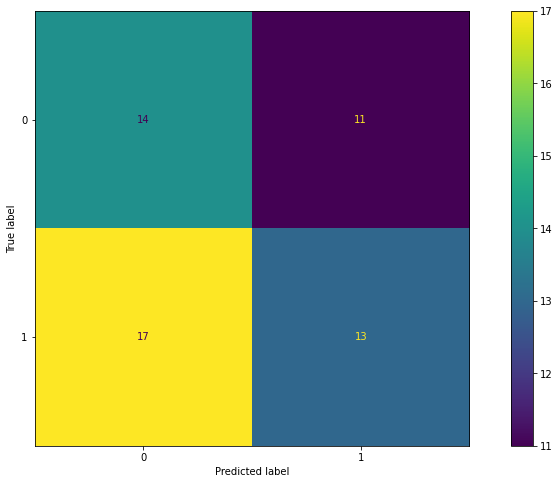

In [65]:
actual = []
predicted = []
count_batch = 0

for inputs,target in test_loader:
  inputs, target = inputs.to(device), target.to(device)
  output = test_model_1(inputs)
  pred = torch.round(output['network_output'])
  count_batch += len(target)
  actual[count_batch-len(target):count_batch] = target
  predicted[count_batch-len(target):count_batch] = pred
  
  prediction_int = np.array([x.item() for x in predicted])
  actual_int = np.array([x.item() for x in actual])

confusion = confusion_matrix(prediction_int,actual_int)
matrix = ConfusionMatrixDisplay(confusion_matrix=confusion)
fig, ax = plt.subplots(figsize=(15,8))
matrix.plot(ax=ax)
plt.show()

In [66]:
y_true = actual_int
y_pred = prediction_int
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

         0.0       0.45      0.56      0.50        25
         1.0       0.54      0.43      0.48        30

    accuracy                           0.49        55
   macro avg       0.50      0.50      0.49        55
weighted avg       0.50      0.49      0.49        55



## Testing with best model

In [74]:
best_model_test = SentimentNet(100,128,1).to(device)

In [75]:
best_model_test.load_state_dict(best_model)

<All keys matched successfully>

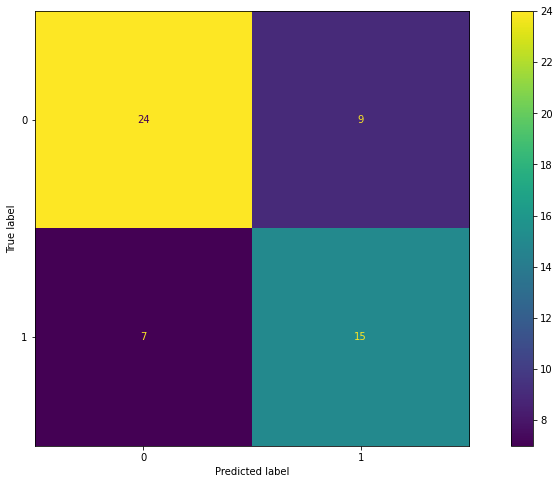

In [76]:
actual = []
predicted = []
count_batch = 0

for inputs,target in test_loader:
  inputs, target = inputs.to(device), target.to(device)
  output = best_model_test(inputs)
  pred = torch.round(output['network_output'])
  count_batch += len(target)
  actual[count_batch-len(target):count_batch] = target
  predicted[count_batch-len(target):count_batch] = pred
  
  prediction_int = np.array([x.item() for x in predicted])
  actual_int = np.array([x.item() for x in actual])

confusion = confusion_matrix(prediction_int,actual_int)
matrix = ConfusionMatrixDisplay(confusion_matrix=confusion)
fig, ax = plt.subplots(figsize=(15,8))
matrix.plot(ax=ax)
plt.show()

In [77]:
y_true = actual_int
y_pred = prediction_int
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

         0.0       0.77      0.73      0.75        33
         1.0       0.62      0.68      0.65        22

    accuracy                           0.71        55
   macro avg       0.70      0.70      0.70        55
weighted avg       0.71      0.71      0.71        55



Best model resulted 71% of accuracy in testing mode.